In [3]:
import pandas as pd
import numpy as np
import 

train_csv = pd.read_csv("../data/train.csv")
test_csv = pd.read_csv("../data/test.csv")



model_data = train_csv


In [4]:
#looking for correlations between number of times a policy view and purchase
#train.groupby(['customer_ID','record_type','A','B','C','D','E','F','G']).size()

#train[['customer_ID','A','B','C','D','E','F','G']][(train.record_type == 1) | (train.shopping_pt == 1)]

sold_records_only = model_data[['customer_ID','shopping_pt','A','B','C','D','E','F','G']][(model_data.record_type == 1)]

model_data['is_last'] = 0

np_model_data = np.asarray(model_data)

#create a column to indicate if this was the last viewed record
for i in range(len(np_model_data)):
    if np_model_data[i][2] == 1:
        np_model_data[i - 1][25] = 1
        #model_data['is_last'].iloc[i - 1] = 1

model_data = pd.DataFrame(np_model_data, columns=model_data.columns.values)


In [5]:
#create a flag to determine if the record was the finally sold record
new_model_data = pd.merge(model_data,sold_records_only,on=['customer_ID','A','B','C','D','E','F','G'], how='outer')

new_model_data['is_final'] = new_model_data['shopping_pt_y'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [7]:

customer_by_product = train_csv.groupby(['customer_ID','A','B','C','D','E','F','G']).size().reset_index()
customer_by_product.columns = ['customer_ID', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'total_viewed']

newer_model_data = pd.merge(new_model_data,customer_by_product,on=['customer_ID','A','B','C','D','E','F','G'])

newer_model_data['is_first'] = new_model_data['shopping_pt_y'].apply(lambda x: 1 if 1 else 0)

newer_model_data.columns

Index([u'customer_ID', u'shopping_pt_x', u'record_type', u'day', u'time',
       u'state', u'location', u'group_size', u'homeowner', u'car_age',
       u'car_value', u'risk_factor', u'age_oldest', u'age_youngest',
       u'married_couple', u'C_previous', u'duration_previous', u'A', u'B',
       u'C', u'D', u'E', u'F', u'G', u'cost', u'is_last', u'shopping_pt_y',
       u'is_final', u'total_viewed', u'is_first'],
      dtype='object')

In [58]:
#we exclude the record where the customer made the purchase and the problem becomes
#trying to predict the is_final column

train = newer_model_data[['day','group_size','homeowner','car_age',\
                          'age_oldest','age_youngest','married_couple',\
                          'cost','is_last','total_viewed','is_first','is_final']][(newer_model_data.record_type != 1)]

#train.replace(np.nan,-1).groupby(['cost']).size()
X = np.asarray(train.ix[:, train.columns != 'is_final'])

y = np.asarray(train.is_final)
#X,y

In [59]:
from  sklearn.cross_validation import train_test_split
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.33,random_state=42)


In [60]:
ml_model = linear_model.LogisticRegression()

In [63]:
ml_logmodel = ml_model.fit(X_train,y_train)

In [64]:
prediction = ml_logmodel.predict(X_test)

In [67]:
l = []
for i in range(len(prediction)):
    if prediction[i] == y_test[i]:
        l.append(1)
    else:
        l.append(0)

In [70]:
results = pd.DataFrame(l,columns=['is_predicted'])

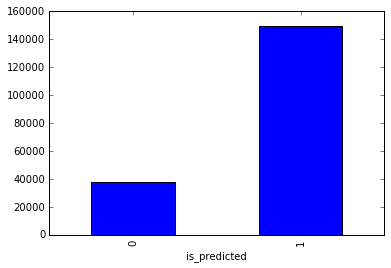

In [76]:
x = results.groupby('is_predicted').size()
import matplotlib.pyplot as plt
%matplotlib inline
x.plot.bar()